### Preprocessing Function

In [743]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils import resample


In [744]:
adult_train = 'adult/adult.data'
adult_test = 'adult/adult.test'
churn ='churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
credit_card = 'creditcard/creditcard.csv'

RANDOM_STATE = 42

In [745]:
def custom_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_val, X_test, y_train, y_val, y_test

def custom_encode(X):
    for col in X.columns:
        if X[col].dtype == 'object':
            X = pd.get_dummies(X, columns=[col], drop_first=True)

    return X

def custom_scale(X):
    for col in X.columns.values:
        if len(X[col].unique()) > 2:
            scalar = StandardScaler()
            X[col] = scalar.fit_transform(X[col].values.reshape(-1, 1))

    return X

def custom_fillna(X):
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna(X[col].mode()[0])
        else:
            X[col] = X[col].fillna(X[col].mean())

    return X

def custom_df_to_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return X, y


In [746]:
def preprocess(choice):
    if choice == 'adult':
        adult_df = fetch_ucirepo(id=2)
        X = adult_df.data.features
        y = adult_df.data.targets
        df = pd.concat([X, y], axis=1)
        df.drop_duplicates(inplace=True)

        # X = df.iloc[:, :-1]
        # y = df.iloc[:, -1]
        X, y = custom_df_to_X_y(df)

        X = X.replace(' ?', np.nan)
        X = custom_fillna(X)

        y = np.where(y == '<=50K', 0, y)
        y = np.where(y == '<=50K.', 0, y)
        y = np.where(y == '>50K', 1, y)
        y = np.where(y == '>50K.', 1, y)
        y = y.astype(int)  # Ensure y is integer

        X = custom_encode(X)
        X = custom_scale(X)

        y = y.flatten()
        y = pd.Series(y)
        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val

    elif choice == 'credit_card':
        df = pd.read_csv(credit_card)
        df = df.drop('Time', axis=1)
        #randomly selected 20000 negative samples + all positive samples
        df = pd.concat([df[df['Class'] == 0].sample(20000, random_state=RANDOM_STATE), df[df['Class'] == 1]])
        # shuffle
        df = df.sample(frac=1, random_state=RANDOM_STATE)

        df.drop_duplicates(inplace=True)

        # split X and y
        # X = df.iloc[:, :-1]
        # y = df.iloc[:, -1]
        X, y = custom_df_to_X_y(df)

        X = custom_encode(X)
        X = custom_scale(X)

        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val
    
    elif choice == 'churn':
        df = pd.read_csv(churn)
        df = df.drop('customerID', axis=1)

        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        df = custom_fillna(df)
        df.drop_duplicates(inplace=True)

        df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

        # X = df.iloc[:, :-1]
        # y = df.iloc[:, -1]
        X, y = custom_df_to_X_y(df)

        X = custom_encode(X)
        X = custom_scale(X)

        # boolean to binary
        for col in X.columns:
            if X[col].dtype == 'bool':
                X[col] = X[col].apply(lambda x: 1 if x == True else 0)

        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val

### K-best Features

In [747]:
def k_best_feature(X_train, y_train, X_val, X_test, top_k, choice):
    if choice == 'information_gain':
        mi_scores = mutual_info_classif(X_train, y_train)
        top_features_idx = np.argsort(mi_scores)[::-1][:top_k]  # top k feature index
        # .iloc for indexing df
        X_train = X_train.iloc[:, top_features_idx]
        X_val = X_val.iloc[:, top_features_idx]
        X_test = X_test.iloc[:, top_features_idx]

        return X_train, X_val, X_test

    elif choice == 'correlation':
        correlation = X_train.corrwith(pd.Series(y_train))
        top_features_idx = correlation.abs().nlargest(top_k).index
        # .loc for indexing df
        X_train = X_train.loc[:, top_features_idx]
        X_val = X_val.loc[:, top_features_idx]
        X_test = X_test.loc[:, top_features_idx]

        return X_train, X_val, X_test


### Base Class for Model

In [748]:
class ParentModel:
    def fit(self, X, y):
        raise NotImplementedError("Subclasses should implement this!")

    def predict(self, X):
        raise NotImplementedError("Subclasses should implement this!")

    def predict_proba(self, X):
        raise NotImplementedError("Subclasses should implement this!")
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)
        
        # TP = np.sum((y == 1) & (y_pred == 1))
        # TN = np.sum((y == 0) & (y_pred == 0))
        # FP = np.sum((y == 0) & (y_pred == 1))
        # FN = np.sum((y == 1) & (y_pred == 0))

        TN, FP, FN, TP = confusion_matrix(y, y_pred).ravel()

        # accuracy = (TP + TN) / (TP + TN + FP + FN)
        # sensitivity = TP / (TP + FN)
        # specificity = TN / (TN + FP)
        # precision = TP / (TP + FP)
        # f1_score = 2 * precision * sensitivity / (precision + sensitivity)
        accuracy = accuracy_score(y, y_pred)
        sensitivity = recall_score(y, y_pred)
        specificity = TN / (TN + FP)
        precision = precision_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auroc = roc_auc_score(y, y_prob)
        auprc = average_precision_score(y, y_prob)

        return accuracy, sensitivity, specificity, precision, f1, auroc, auprc


### Logistic Regression

In [749]:
class LogisticRegression(ParentModel):
    def __init__(self,learning_rate=1, max_epoch=1000):
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        z = np.array(z)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for epoch in range(self.max_epoch):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            dw = np.dot(X.T, (y_pred - y)) / X.shape[0]
            db = np.mean(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return y_pred
    

### Bagging

In [750]:
class Bagging(ParentModel):
    def __init__(self, base_model, n_estimators=9, random_seed=RANDOM_STATE):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:
            print('X is not a DataFrame')  
            return X[indices], y[indices]

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            model = self.base_model()
            X_sample, y_sample = self.bootstrap_sample(X, y)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def get_models(self):
        return self.models
    
    def evaluate(self, X, y):
        accuracies = []
        sensitivities = []
        specificities = []
        precisions = []
        f1_scores = []
        aurocs = []
        auprcs = []

        for model in self.models:
            acc, sen, spe, pre, f1, auroc, auprc = model.evaluate(X, y)
            accuracies.append(acc)
            sensitivities.append(sen)
            specificities.append(spe)
            precisions.append(pre)
            f1_scores.append(f1)
            aurocs.append(auroc)
            auprcs.append(auprc)

        accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
        sensitivity_mean, sensitivity_std = np.mean(sensitivities), np.std(sensitivities)
        specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)
        precision_mean, precision_std = np.mean(precisions), np.std(precisions)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
        auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
        auprc_mean, auprc_std = np.mean(auprcs), np.std(auprcs)

        return (accuracy_mean, accuracy_std, 
                sensitivity_mean, sensitivity_std, 
                specificity_mean, specificity_std, 
                precision_mean, precision_std, 
                f1_mean, f1_std, auroc_mean, auroc_std, auprc_mean, auprc_std)


### Stacking

In [751]:
class Stacking(ParentModel):
    def __init__(self, base_model, meta_model, n_estimators=9,models=[],random_seed=RANDOM_STATE):
        self.base_model = base_model
        self.meta_model = meta_model()
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  
            return X[indices], y[indices]

    def fit(self, X_train, y_train, X_val, y_val):
        # base models
        base_train_preds = np.zeros((X_val.shape[0], self.n_estimators))
        for i in range(self.n_estimators):
            
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model()
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)

            base_train_preds[:, i] = model.predict(X_val)

        # base model predictions + original val set feature
        X_meta_train = np.hstack((X_val, base_train_preds))

        # meta train
        self.meta_model.fit(X_meta_train, y_val)

    def predict(self, X_test):
        # base models preds
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)

        # base model predictions + original test set features
        X_meta_test = np.hstack((X_test, base_test_preds))

        # meta prediction
        return self.meta_model.predict(X_meta_test)
    
    def predict_proba(self, X_test):
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)
            
        X_meta_test = np.hstack((X_test, base_test_preds))

        return self.meta_model.predict_proba(X_meta_test)


### Voting

In [752]:
class VotingClassifier(ParentModel):
    def __init__(self, base_model, n_estimators=9,models=[],random_seed=RANDOM_STATE):
        self.base_model = base_model
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        np.random.seed(self.random_seed)

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)

        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  
            return X[indices], y[indices]
        
    def fit(self, X_train, y_train):
        for i in range(self.n_estimators):
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model()
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)
            
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        y_pred = np.mean(predictions, axis=0)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        
        return y_pred
    
    def predict_proba(self, X):
        predictions = np.array([model.predict_proba(X) for model in self.models])
        y_prob = np.mean(predictions, axis=0)
        # y_prob = np.median(predictions, axis=0)

        return y_prob

### Main

In [753]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    best_model = None
    best_f1 = 0
    best_hyperparameters = None

    # change lr and max_epoch
    for lr in [0.001, 0.01, 0.1,1]:
        for max_epoch in [100, 500, 1000]:
            model = LogisticRegression(learning_rate=lr, max_epoch=max_epoch)
            model.fit(X_train, y_train)
            _, _, _, _, f1_score, _, _ = model.evaluate(X_val, y_val)

            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = model
                best_hyperparameters = (lr, max_epoch)

    return best_model, best_hyperparameters


def test(choice):
    X_train, X_test, X_val, y_train, y_test, y_val = preprocess(choice)
    #X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, 20, 'information_gain')
    X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, 20, 'correlation')

    print(f'Dataset: {choice}')

    model = LogisticRegression()
    model.fit(X_train, y_train)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = model.evaluate(X_test, y_test)

    lr_metrics = [accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc]
   
    model = Bagging(LogisticRegression, n_estimators=9)
    model.fit(X_train, y_train)
    accuracy_mean, accuracy_std, sensitivity_mean, sensitivity_std, specificity_mean, specificity_std, precision_mean, precision_std, f1_mean, f1_std, auroc, auroc_std, auprc, auprc_std = model.evaluate(X_test, y_test)

    lr_bagging_metrics = [
         (f"{accuracy_mean:.6f} ± {accuracy_std:.6f}"),
        (f"{sensitivity_mean:.6f} ± {sensitivity_std:.6f}"),
        (f"{specificity_mean:.6f} ± {specificity_std:.6f}"),
        (f"{precision_mean:.6f} ± {precision_std:.6f}"),
        (f"{f1_mean:.6f} ± {f1_std:.6f}"),
        (f"{auroc:.6f} ± {auroc_std:.6f}"),
        (f"{auprc:.6f} ± {auprc_std:.6f}")
    ]

    # Stacking 
    models = model.get_models()
    stacking = Stacking(LogisticRegression, LogisticRegression, n_estimators=9, models=models)
    stacking.fit(X_train, y_train, X_val, y_val)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = stacking.evaluate(X_test, y_test)

    stacking_metrics = [accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc]

    # Voting 
    voting = VotingClassifier(LogisticRegression, n_estimators=9, models=models)
    voting.fit(X_train, y_train)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = voting.evaluate(X_test, y_test)

    voting_metrics = [accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc]

    data = {
        "Method": ["LR", "Voting ensemble", "Stacking ensemble"],
        "Accuracy": [lr_bagging_metrics[0], f"{voting_metrics[0]:.6f}", f"{stacking_metrics[0]:.6f}"],
        "Sensitivity": [lr_bagging_metrics[1], f"{voting_metrics[1]:.6f}", f"{stacking_metrics[1]:.6f}"],
        "Specificity": [lr_bagging_metrics[2], f"{voting_metrics[2]:.6f}", f"{stacking_metrics[2]:.6f}"],
        "Precision": [lr_bagging_metrics[3], f"{voting_metrics[3]:.6f}", f"{stacking_metrics[3]:.6f}"],
        "F1-score": [lr_bagging_metrics[4], f"{voting_metrics[4]:.6f}", f"{stacking_metrics[4]:.6f}"],
        "AUROC": [lr_bagging_metrics[5], f"{voting_metrics[5]:.6f}", f"{stacking_metrics[5]:.6f}"],
        "AUPRC": [lr_bagging_metrics[6], f"{voting_metrics[6]:.6f}", f"{stacking_metrics[6]:.6f}"],
    }

    df = pd.DataFrame(data)
    
    pd.set_option('display.colheader_justify', 'center')

    metrics = []
    labels = []
    for i, modl in enumerate(model.models):
        accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = modl.evaluate(X_test, y_test)
        metrics.append([accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc])
        labels.append(f'Model {i + 1}')

    return df,metrics, labels



In [755]:
churn_metrics_df,metrics_churn , labels_churn = test('churn')
churn_metrics_df

Dataset: churn


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.792803 ± 0.005181,0.531250 ± 0.015959,0.880236 ± 0.008357,0.597635 ± 0.013881,0.562250 ± 0.010030,0.844910 ± 0.002059,0.618267 ± 0.003392
1,Voting ensemble,0.792883,0.534091,0.879392,0.596825,0.563718,0.845872,0.621621
2,Stacking ensemble,0.790747,0.556818,0.868946,0.586826,0.571429,0.839178,0.614321


In [756]:
adult_metrics_df,metrics_adult , labels_adult = test('adult')
adult_metrics_df

Dataset: adult


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.847554 ± 0.000398,0.592220 ± 0.005409,0.930230 ± 0.001800,0.733266 ± 0.003397,0.655209 ± 0.002189,0.898462 ± 0.000186,0.756068 ± 0.000671
1,Voting ensemble,0.848202,0.593802,0.930576,0.734715,0.656786,0.898607,0.756379
2,Stacking ensemble,0.846461,0.573702,0.934780,0.740140,0.646379,0.898754,0.756835


In [759]:
credit_metrics_df, metrics_credit_card , labels_credit_card = test('credit_card')
credit_metrics_df

Dataset: credit_card


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.996181 ± 0.000204,0.897119 ± 0.002910,0.998879 ± 0.000210,0.956208 ± 0.007730,0.925702 ± 0.003710,0.991603 ± 0.002226,0.947057 ± 0.003499
1,Voting ensemble,0.996317,0.898148,0.998991,0.960396,0.928230,0.992632,0.948643
2,Stacking ensemble,0.996317,0.898148,0.998991,0.960396,0.928230,0.984830,0.941390


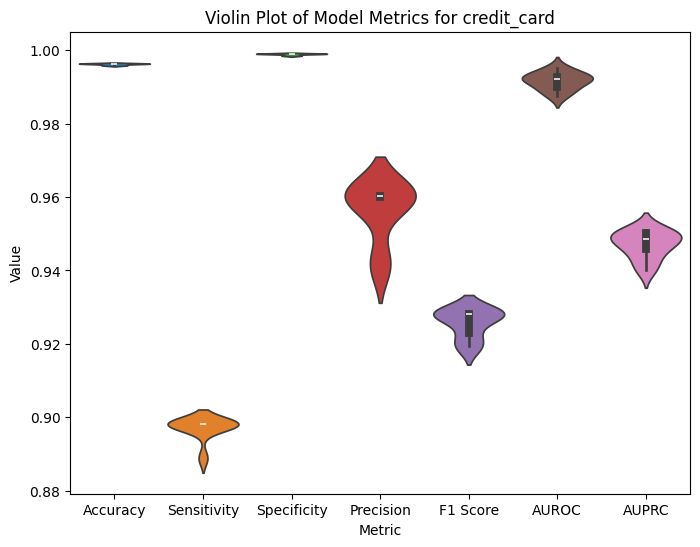

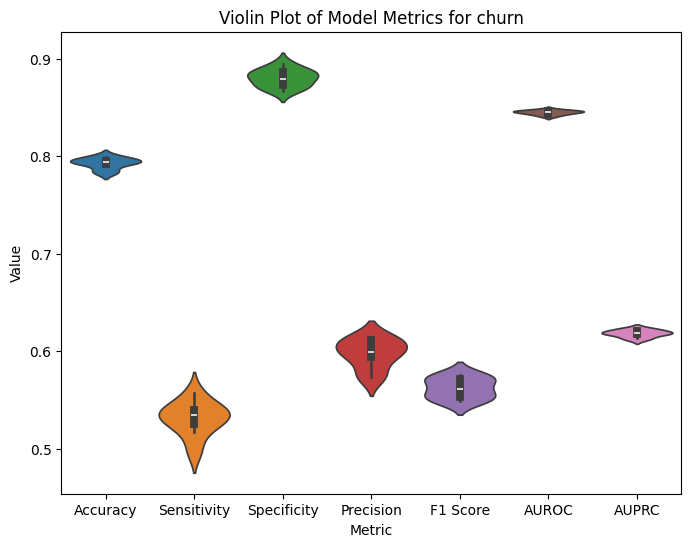

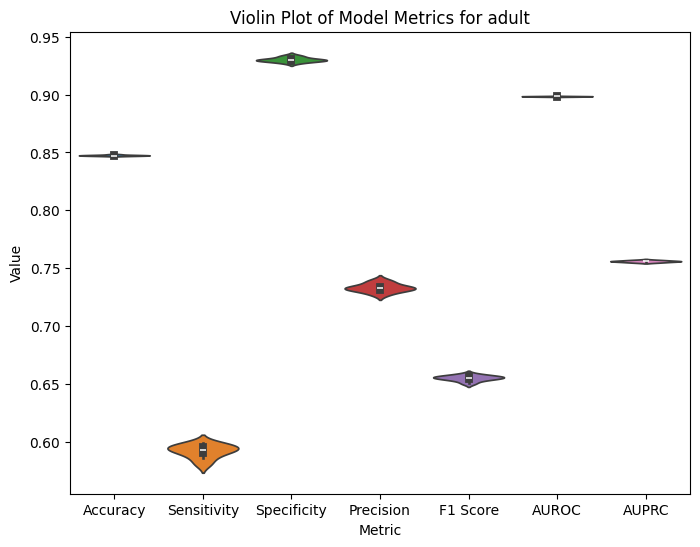

In [757]:
def plot_metrics(metrics, labels, choice):
    metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUROC', 'AUPRC']
    df = pd.DataFrame(metrics, columns=metric_names)
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df)
    plt.title('Violin Plot of Model Metrics for' + ' ' + choice)
    plt.ylabel('Value')
    plt.xlabel('Metric')
    plt.show()

plot_metrics(metrics_credit_card, labels_credit_card, 'credit_card')
plot_metrics(metrics_churn, labels_churn, 'churn')
plot_metrics(metrics_adult, labels_adult, 'adult')

In [758]:
churn_metrics_df.to_clipboard(excel=True, sep='\t', index=False)
adult_metrics_df.to_clipboard(excel=True, sep='\t', index=False)
credit_metrics_df.to_clipboard(excel=True, sep='\t', index=False)